## LOADING THE LIBRARIES

In [ ]:
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets
from torchvision.datasets import DatasetFolder
import torchvision.transforms as transforms

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

## LOADING THE DATASET

# New section

In [ ]:
!pip install -q opendatasets

In [ ]:
# Citation for the dataset
# Dataset obtained from Kaggle:
# Shakya Dissanayake. (2021). Oily, Dry, and Normal Skin Types Dataset. Kaggle. https://www.kaggle.com/datasets/shakyadissanayake/oily-dry-and-normal-skin-types-dataset

In [ ]:
import opendatasets as od
import pandas as pd

od.download('https://www.kaggle.com/datasets/shakyadissanayake/oily-dry-and-normal-skin-types-dataset/download?datasetVersionNumber=1')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: xkufiz
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/shakyadissanayake/oily-dry-and-normal-skin-types-dataset


100%|██████████| 124M/124M [00:01<00:00, 111MB/s]


RESIZING MY IMAGES

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

Splitting to Test and Train

In [ ]:
train_dataset = datasets.ImageFolder("./oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/train", transform=train_transform)
test_dataset = datasets.ImageFolder("./oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/test", transform=test_transform)
train_ratio = 0.9
val_ratio = 1 - train_ratio

train_size = int(train_ratio * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

print(f'Original train set has {len(train_dataset)} samples')
print(f'Train set has {len(train_subset)} samples')
print(f'Validation set has {len(val_subset)} samples')
print(f'Test set has {len(test_dataset)} samples')

Original train set has 2756 samples
Train set has 2480 samples
Validation set has 276 samples
Test set has 134 samples


In [ ]:
use_augmentation = True
base_transform = transforms.Compose([
    transforms.ToTensor()
])
if use_augmentation:
    aug_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5)
    ])
    transform = transforms.Compose([aug_transform, base_transform])
else:
    transform = base_transform

SPLITTING THE DATA

In [ ]:
batch_size = 32

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Printing samples

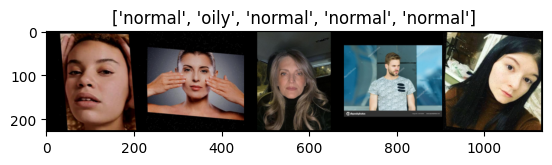

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

train_loader_for_vis = DataLoader(train_subset, batch_size=5, shuffle=True, num_workers=0)
inputs, classes = next(iter(train_loader_for_vis))

out = torchvision.utils.make_grid(inputs)

class_names = ['dry', 'normal', 'oily']

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(4, 4, 0),
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*14*14, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 7)
        )

    def forward(self, x):
        x = self.cnn_layers(x)

        x = x.flatten(1)

        x = self.fc_layers(x)
        return x

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MyCNN()
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [ ]:
n_epochs = 10

best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    model.train()
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):


        optimizer.zero_grad()

        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = model(imgs)

        loss = criterion(logits, labels)

        loss.backward()


        optimizer.step()

        acc = (logits.argmax(dim=-1) == labels).float().mean()

        train_loss.append(loss.item())
        train_accs.append(acc.item())

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    model.eval()
    valid_loss = []
    valid_accs = []
    for batch in tqdm(valid_loader):

        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
          logits = model(imgs)

        loss = criterion(logits, labels)

        acc = (logits.argmax(dim=-1) == labels).float().mean()

        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')

    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[Epoch: 001/010] Train: loss=1.13368, acc=0.38702 | Valid: loss=1.11508, acc=0.31111


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[Epoch: 002/010] Train: loss=1.08980, acc=0.38301 | Valid: loss=1.06225, acc=0.42917


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[Epoch: 003/010] Train: loss=1.07097, acc=0.41106 | Valid: loss=1.06374, acc=0.42639


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[Epoch: 004/010] Train: loss=1.04566, acc=0.45873 | Valid: loss=1.00608, acc=0.49097


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[Epoch: 005/010] Train: loss=0.97512, acc=0.52324 | Valid: loss=0.96845, acc=0.56319


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[Epoch: 006/010] Train: loss=0.86318, acc=0.61338 | Valid: loss=0.91076, acc=0.60972


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[Epoch: 007/010] Train: loss=0.72484, acc=0.69231 | Valid: loss=0.84546, acc=0.62014


  0%|          | 0/78 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2f9c997370>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2f9c997370>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

  0%|          | 0/9 [00:00<?, ?it/s]

[Epoch: 008/010] Train: loss=0.54982, acc=0.78085 | Valid: loss=0.80722, acc=0.65417


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[Epoch: 009/010] Train: loss=0.38142, acc=0.86098 | Valid: loss=0.77129, acc=0.71875


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[Epoch: 010/010] Train: loss=0.24361, acc=0.90585 | Valid: loss=0.92094, acc=0.71250


In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

test_loss = []
test_accs = []

for batch in tqdm(test_loader):
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        logits = model(imgs)
        loss = criterion(logits, labels)
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        test_loss.append(loss.item())
        test_accs.append(acc.item())

test_loss = sum(test_loss) / len(test_loss)
test_acc = sum(test_accs) / len(test_accs)

print(f"Test: loss={test_loss:.5f}, acc={test_acc:.5f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Test: loss=2.06661, acc=0.37292


  0%|          | 0/5 [00:00<?, ?it/s]

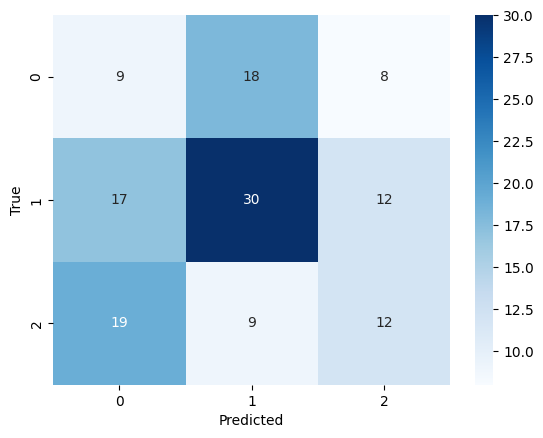

              precision    recall  f1-score   support

           0       0.20      0.26      0.23        35
           1       0.53      0.51      0.52        59
           2       0.38      0.30      0.33        40

    accuracy                           0.38       134
   macro avg       0.37      0.36      0.36       134
weighted avg       0.40      0.38      0.39       134



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
all_preds = []
all_labels = []

model.eval()
for batch in tqdm(test_loader):
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        logits = model(imgs)
        preds = logits.argmax(dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print(classification_report(all_labels, all_preds))

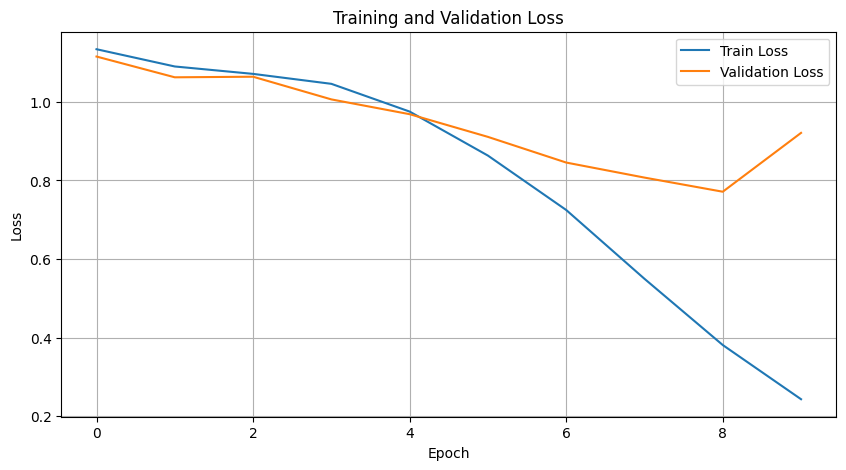

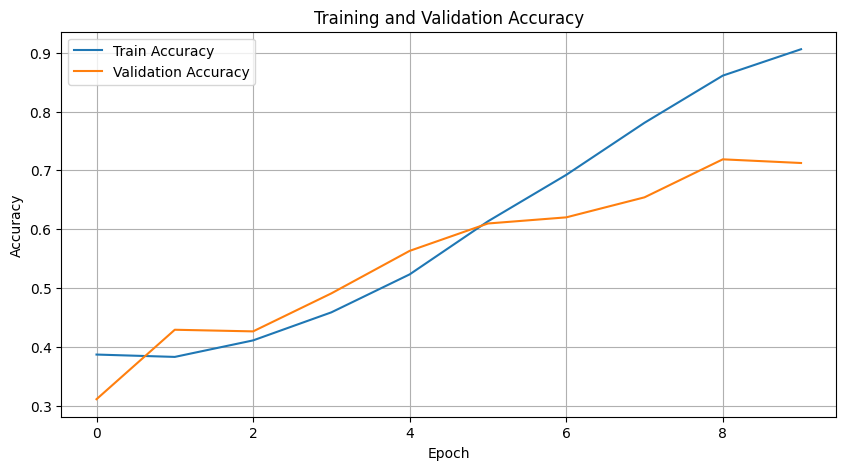

In [ ]:
zimport matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
torch.save(model.state_dict(), 'final_model.pth')

In [ ]:
model.load_state_dict(torch.load('final_model.pth'))
model.eval()

MyCNN(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=50176, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=7, bias=True)
  )
)

## Hyperparameter Tuning
Experiment with Different Hyperparameters: Explore different learning rates, batch sizes, and network architectures to further improve performance.
Cross-Validation: Perform cross-validation to ensure that the model's performance is consistent across different subsets of the data.

##   Data Augmentation and Preprocessing
Augment Data: Use data augmentation techniques to increase the diversity of your training data and improve generalization.
Normalization and Standardization: Ensure your data is properly normalized or standardized.


## RESNET-18

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 127MB/s]


In [ ]:
n_epochs = 10

best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):
    model.train()
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        acc = (logits.argmax(dim=-1) == labels).float().mean()
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    model.eval()
    valid_loss = []
    valid_accs = []

    for batch in tqdm(valid_loader):
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            logits = model(imgs)
            loss = criterion(logits, labels)
            acc = (logits.argmax(dim=-1) == labels).float().mean()

        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_resnet_model.pth')

    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

# Final test set evaluation
model.load_state_dict(torch.load('best_resnet_model.pth'))
model.eval()

test_loss = []
test_accs = []

for batch in tqdm(test_loader):
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        logits = model(imgs)
        loss = criterion(logits, labels)
        acc = (logits.argmax(dim=-1) == labels).float().mean()

    test_loss.append(loss.item())
    test_accs.append(acc.item())

test_loss = sum(test_loss) / len(test_loss)
test_acc = sum(test_accs) / len(test_accs)

print(f"Test: loss={test_loss:.5f}, acc={test_acc:.5f}")

100%|██████████| 9/9 [00:02<00:00,  3.30it/s]


[Epoch: 001/010] Train: loss=1.16790, acc=0.41266 | Valid: loss=1.01604, acc=0.48194


100%|██████████| 9/9 [00:01<00:00,  5.53it/s]


[Epoch: 002/010] Train: loss=1.04543, acc=0.48037 | Valid: loss=1.23190, acc=0.48056


100%|██████████| 9/9 [00:01<00:00,  5.69it/s]


[Epoch: 003/010] Train: loss=0.95546, acc=0.54367 | Valid: loss=1.00280, acc=0.50278


100%|██████████| 9/9 [00:01<00:00,  5.59it/s]


[Epoch: 004/010] Train: loss=0.85096, acc=0.61779 | Valid: loss=0.93971, acc=0.56111


100%|██████████| 9/9 [00:01<00:00,  5.37it/s]


[Epoch: 005/010] Train: loss=0.74580, acc=0.67308 | Valid: loss=1.09280, acc=0.49097


100%|██████████| 9/9 [00:01<00:00,  5.69it/s]


[Epoch: 006/010] Train: loss=0.60743, acc=0.75080 | Valid: loss=1.05843, acc=0.59444


100%|██████████| 9/9 [00:01<00:00,  5.46it/s]


[Epoch: 007/010] Train: loss=0.43859, acc=0.82131 | Valid: loss=0.74365, acc=0.74861


100%|██████████| 9/9 [00:02<00:00,  3.75it/s]


[Epoch: 008/010] Train: loss=0.31629, acc=0.88502 | Valid: loss=1.59911, acc=0.54306


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


[Epoch: 009/010] Train: loss=0.26101, acc=0.90705 | Valid: loss=1.35989, acc=0.65417


100%|██████████| 9/9 [00:01<00:00,  5.69it/s]


[Epoch: 010/010] Train: loss=0.19631, acc=0.92708 | Valid: loss=1.14911, acc=0.67222


100%|██████████| 5/5 [00:00<00:00,  5.80it/s]

Test: loss=1.97567, acc=0.30208


100%|██████████| 5/5 [00:00<00:00,  5.83it/s]


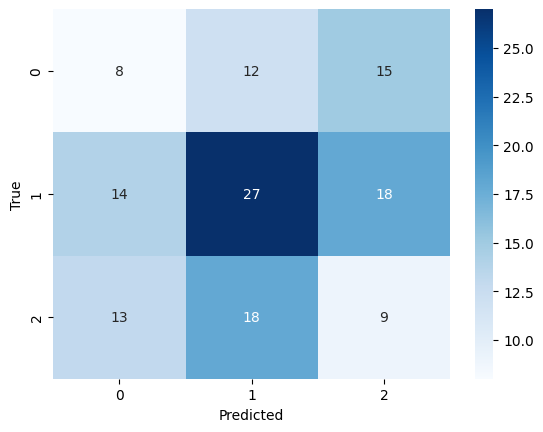

              precision    recall  f1-score   support

           0       0.23      0.23      0.23        35
           1       0.47      0.46      0.47        59
           2       0.21      0.23      0.22        40

    accuracy                           0.33       134
   macro avg       0.31      0.30      0.30       134
weighted avg       0.33      0.33      0.33       134



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the test set
all_preds = []
all_labels = []

model.eval()
for batch in tqdm(test_loader):
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        logits = model(imgs)
        preds = logits.argmax(dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print(classification_report(all_labels, all_preds))


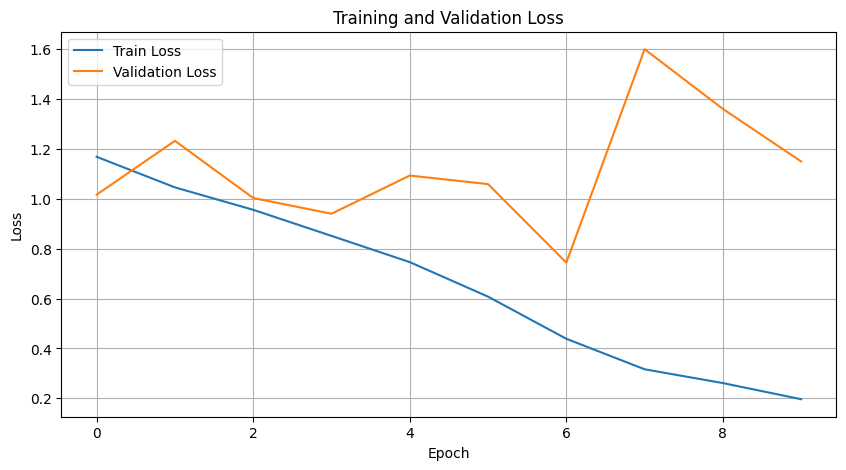

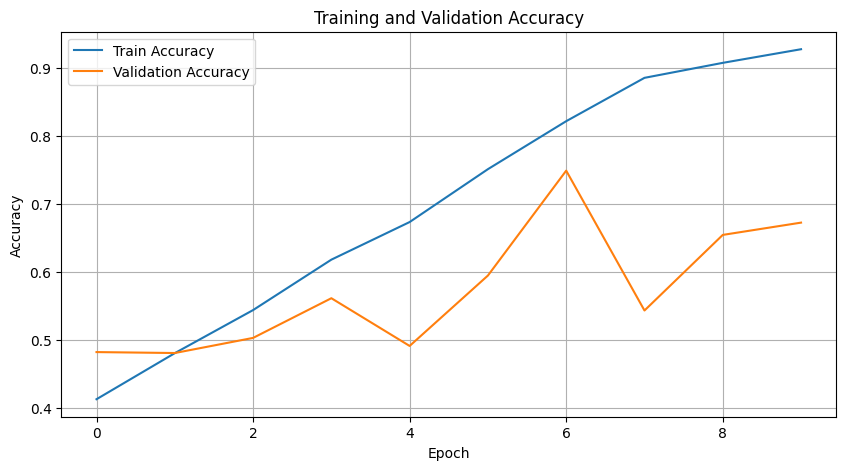

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

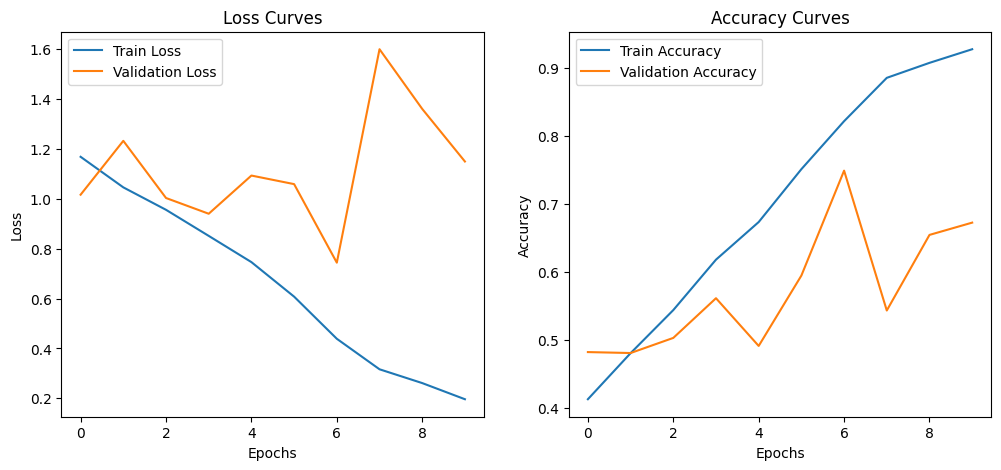

In [ ]:
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.show()


In [ ]:
torch.save(model.state_dict(), 'best_resnet_model.pth')

In [ ]:
model.load_state_dict(torch.load('best_resnet_model.pth'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  